<a href="https://colab.research.google.com/github/maciejskorski/binomial_moments/blob/main/BinomialMoments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

This notebook shows how to compute moments of the binomial distribution $\mathrm{Binom}(n,p)$.

Central moments are **better expressed in terms of the variance** $\sigma^2 = p(1-p)$ instead of $p$.

In [19]:
import itertools
import sympy as sm
from sympy import Symbol
from sympy import polys
from sympy.functions.combinatorial.numbers import stirling,factorial,binomial
from sympy.functions.combinatorial.factorials import FallingFactorial

## Implementation

In [95]:
n=Symbol('n')
p=Symbol('p')
q=Symbol('q')
s=Symbol('sigma')

def raw_binom_moment(d=2):
  outs = [binomial(n,k)*factorial(k)*stirling(d,k,kind=2)*p**k for k in range(d+1)]
  return sum(outs)

def central_binom_moment1(d=2):
  ''' output as a poly in number of trials n and succes prob p '''
  out = 0
  for k in range(d+1):
    out +=  binomial(d,d-k) * (-n*p)**k * raw_binom_moment(d=d-k)
  out = out.simplify().simplify() # NOTE: a bug in Sympy requires to simplify twice...
  return out

def multinomial_coef(n,ks):
  if n!=sum(ks):
    return 0
  elif len(ks)==1:
    return 1
  else:
    return binomial(n,ks[0])*multinomial_coef(n-ks[0],ks[1:])

def central_binom_moment2(d=2):
  ''' output as poly in number of trials n, success prob p and q=1-p '''
  out = 0
  for k in range(1,int(d/2)+1):
    tmp = 0
    for dks in itertools.product(range(2,d+1),repeat=k):
      polyx = multinomial_coef(d,dks)
      for dk in dks:
        polyx = polyx * (q**(dk-1)-(-p)**(dk-1))
      tmp = tmp + polyx
    out = out + binomial(n,k) * (p*q)**k * tmp

  return out.simplify()

def central_binom_moment_pretty1(d=2):
  ''' output as polynomial in number of trials and success variance '''

  out = central_binom_moment2(d=d).combsimp()
  out = out.subs(q,1-p)
  if d % 2 == 0:
    out = polys.groebner([out,s**2-p*(1-p)],p,n,s,order='lex')[-1]
  elif d % 2 == 1:
    out = polys.div(out,1-2*p)[0]
    out = polys.groebner([out,s**2-p*(1-p)],p,n,s,order='lex')[-1]
    out = (1-2*p)*out
  return out

def central_binom_moment_pretty2(d=2):
  ''' output as polynomial in number of trials and success variance '''

  out = central_binom_moment2(d=d)
  if d % 2 == 0:
    out = polys.symmetrize(out,gens=[p,q])[0]
  elif d % 2 == 1:
    out = polys.div(out,1-2*p)[0]
    out = polys.symmetrize(out,gens=[p,q])[0]
    out = (1-2*p)*out
  out = out.subs(p+q,1)
  out = out.subs(p*q,s**2)
  return out

## Visualization

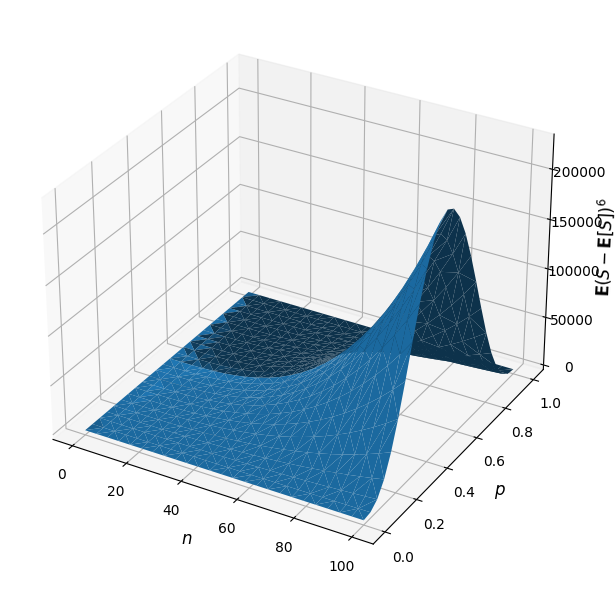

In [102]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sympy import lambdify

fun = central_binom_moment1(d=6)
fun = lambdify([n,p],fun)

n_grid = 25

ns = np.linspace(0,100,n_grid)
ps = np.linspace(0,1,n_grid)

ns,ps = np.meshgrid(ns,ps)
z = fun(ns,ps)

fig = plt.figure(figsize=(8,6))
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(ns.ravel(),ps.ravel(),z.ravel())

ax.set_xlabel('$n$', fontsize=12)
ax.set_ylabel('$p$', fontsize=12)
ax.set_zlabel('$\mathbf{E}(S-\mathbf{E}[S])^6$', fontsize=12)

plt.tight_layout()
plt.show()

In [103]:
import pandas as pd

df = pd.DataFrame([ns.ravel(),ps.ravel(),z.ravel()]).T
df = df.sort_values([0,1])
df.to_csv('binomial_moments.txt',index=False)

## Formulas for Raw Binomial Moment

In [104]:
from sympy import init_printing
init_printing()

import pandas as pd

out = [(d,raw_binom_moment(d=d)) for d in range(2,11)]
out = pd.DataFrame(out,columns=['order','formula'])
pd.set_option('display.max_colwidth', None)
out

## to latex:
#out['latex'] = out['formula'].apply(lambda s: '$'+sm.latex(s)+'$')
#print(out[['latex']].to_latex(escape=False))

,order,formula
0,2,"n*p + 2*p**2*binomial(n, 2)"
1,3,"n*p + 6*p**3*binomial(n, 3) + 6*p**2*binomial(n, 2)"
2,4,"n*p + 24*p**4*binomial(n, 4) + 36*p**3*binomial(n, 3) + 14*p**2*binomial(n, 2)"
3,5,"n*p + 120*p**5*binomial(n, 5) + 240*p**4*binomial(n, 4) + 150*p**3*binomial(n, 3) + 30*p**2*binomial(n, 2)"
4,6,"n*p + 720*p**6*binomial(n, 6) + 1800*p**5*binomial(n, 5) + 1560*p**4*binomial(n, 4) + 540*p**3*binomial(n, 3) + 62*p**2*binomial(n, 2)"
5,7,"n*p + 5040*p**7*binomial(n, 7) + 15120*p**6*binomial(n, 6) + 16800*p**5*binomial(n, 5) + 8400*p**4*binomial(n, 4) + 1806*p**3*binomial(n, 3) + 126*p**2*binomial(n, 2)"
6,8,"n*p + 40320*p**8*binomial(n, 8) + 141120*p**7*binomial(n, 7) + 191520*p**6*binomial(n, 6) + 126000*p**5*binomial(n, 5) + 40824*p**4*binomial(n, 4) + 5796*p**3*binomial(n, 3) + 254*p**2*binomial(n, 2)"
7,9,"n*p + 362880*p**9*binomial(n, 9) + 1451520*p**8*binomial(n, 8) + 2328480*p**7*binomial(n, 7) + 1905120*p**6*binomial(n, 6) + 834120*p**5*binomial(n, 5) + 186480*p**4*binomial(n, 4) + 18150*p**3*binomial(n, 3) + 510*p**2*binomial(n, 2)"
8,10,"n*p + 3628800*p**10*binomial(n, 10) + 16329600*p**9*binomial(n, 9) + 30240000*p**8*binomial(n, 8) + 29635200*p**7*binomial(n, 7) + 16435440*p**6*binomial(n, 6) + 5103000*p**5*binomial(n, 5) + 818520*p**4*binomial(n, 4) + 55980*p**3*binomial(n, 3) + 1022*p**2*binomial(n, 2)"


## Formulas for Central Moment

In [105]:
import pandas as pd

out = [(d,central_binom_moment_pretty1(d=d).factor()) for d in range(2,11)]
out = pd.DataFrame(out,columns=['order','formula'])
out

## to latex:
#out['latex'] = out['formula'].apply(lambda s: '$'+sm.latex(s)+'$')
#print(out[['latex']].to_latex(escape=False))

,order,formula
0,2,n*sigma**2
1,3,-n*sigma**2*(2*p - 1)
2,4,n*sigma**2*(3*n*sigma**2 - 6*sigma**2 + 1)
3,5,-n*sigma**2*(2*p - 1)*(10*n*sigma**2 - 12*sigma**2 + 1)
4,6,n*sigma**2*(15*n**2*sigma**4 - 130*n*sigma**4 + 25*n*sigma**2 + 120*sigma**4 - 30*sigma**2 + 1)
5,7,-n*sigma**2*(2*p - 1)*(105*n**2*sigma**4 - 462*n*sigma**4 + 56*n*sigma**2 + 360*sigma**4 - 60*sigma**2 + 1)
6,8,n*sigma**2*(105*n**3*sigma**6 - 2380*n**2*sigma**6 + 490*n**2*sigma**4 + 7308*n*sigma**6 - 2156*n*sigma**4 + 119*n*sigma**2 - 5040*sigma**6 + 1680*sigma**4 - 126*sigma**2 + 1)
7,9,-n*sigma**2*(2*p - 1)*(1260*n**3*sigma**6 - 13216*n**2*sigma**6 + 1918*n**2*sigma**4 + 32112*n*sigma**6 - 6948*n*sigma**4 + 246*n*sigma**2 - 20160*sigma**6 + 5040*sigma**4 - 252*sigma**2 + 1)
8,10,n*sigma**2*(945*n**4*sigma**8 - 44100*n**3*sigma**8 + 9450*n**3*sigma**6 + 303660*n**2*sigma**8 - 99120*n**2*sigma**6 + 6825*n**2*sigma**4 - 623376*n*sigma**8 + 240840*n*sigma**6 - 24438*n*sigma**4 + 501*n*sigma**2 + 362880*sigma**8 - 151200*sigma**6 + 17640*sigma**4 - 510*sigma**2 + 1)
